<a href="https://colab.research.google.com/github/institutohumai/machine_learning/blob/main/9_SeriesDeTiempo/Prophet.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>

# Prophet

In [1]:
import itertools
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly
from matplotlib import pyplot as plt
from plotly import offline as py
plt.rcParams["figure.figsize"] = (20,5)


In [2]:
# importamos datos abiertos del servicio de meteorologia y atmósfera
# link: https://www.ncdc.noaa.gov/data-access
# datos anuales desde 1880 a 2021

## Trabando sobre datos climáticos
importamos datos abiertos del servicio de meteorologia y atmósfera

link: https://www.ncdc.noaa.gov/data-access

datos anuales desde 1880 a 2021

In [3]:
data = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/monthly_temp.csv')
data.ds = pd.to_datetime(data.ds)
train = data.copy()
train.head(10)

,ds,y
0,1895-01-01,26.69
1,1895-02-01,26.60
2,1895-03-01,39.97
3,1895-04-01,52.90
4,1895-05-01,59.94
5,1895-06-01,67.80
6,1895-07-01,71.24
7,1895-08-01,71.62
8,1895-09-01,65.57
9,1895-10-01,50.85


In [4]:
train.tail(10)

,ds,y
1509,2020-10-01,54.30
1510,2020-11-01,46.33
1511,2020-12-01,35.73
1512,2021-01-01,34.59
1513,2021-02-01,30.58
1514,2021-03-01,45.54
1515,2021-04-01,51.85
1516,2021-05-01,60.35
1517,2021-06-01,72.63
1518,2021-07-01,75.47


In [5]:
# generamos un dataset futuro para hacer la prediccion, desde
# 2021 a 2090
futuro = pd.DataFrame({'ds': pd.to_datetime(
    [x for x in range(2021, 2090)], format='%Y'), 'y': np.nan})

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/apbh6c6c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/6f940cfs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13300', 'data', 'file=/tmp/tmpkw2hsb6k/apbh6c6c.json', 'init=/tmp/tmpkw2hsb6k/6f940cfs.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_modelea4t6m4s/prophet_model-20230706025520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


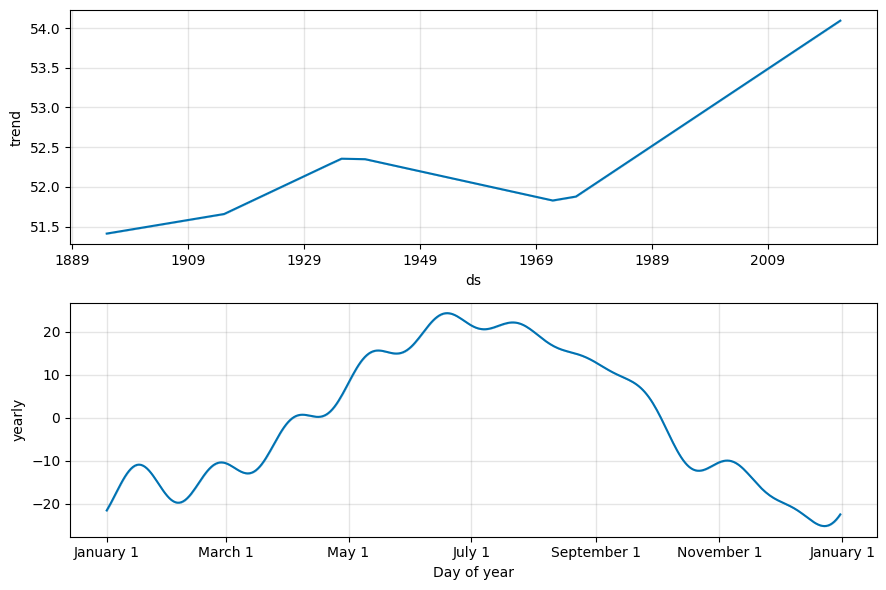

In [6]:
# instanciamos modelo
m = Prophet()

# fiteamos el modelo en TRAIN
m.fit(train)

# predecimos en futuro
forecast = m.predict(futuro)

# para graficar, hacemos predict tambien en train
forecast_train = m.predict(train)

# #unimos los dos DFs para visualizar las dos partes, train-prediccion
forecast_final = pd.concat([forecast_train, forecast])

# #plot componentes del forecast
m.plot_components(forecast_train);

In [7]:
# vemos como prophet captura la estacionalidad anual y la tendencia creciente.

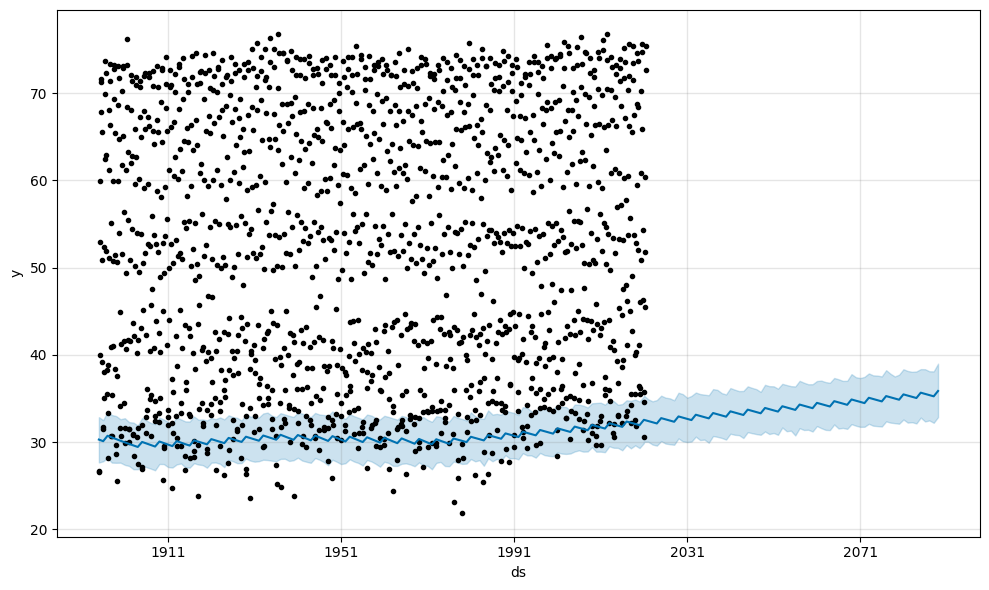

In [8]:
m.plot(forecast_final[forecast_final['ds'].dt.month==1])
plt.show()

In [9]:
# podemos pasar una grilla de hiperparámetros y probar con rolloing cross validation
# el set que minimiza el error. En este caso el MAE. Luego repetimos la prediccion
# con el mejor set de hiperparámetros.

# nombrar hiperparametros mas importantes, changepoint_prior_scale y changepoint range. como funcionan.
# prophet tambine puede recibir regresores de una matriz de datos.
# fechas de feriados para argentina y otros paises, etc.


param_grid = {
    'changepoint_prior_scale': [0.001, 0.05],  # default 0.05
    'seasonality_prior_scale': [10.0, 0.01, 1.0],  # default 10
    'seasonality_mode': ["additive", "multiplicative"]}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here
counter = 1
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    print(counter)
    counter = counter + 1

    m.fit(train)  # Fit model with given params

    initial_forecast_date = '1980-01-01'
    initial = str(
        abs(data[data.ds > initial_forecast_date].shape[0] - data.shape[0])) + ' days'

# tendremos 100 años de entrenamiento fijos
# luego haremos predicciones cada 10 años de 5 años de ventana de prediccion
# sucesivamente hasta que los datos se agoten.

    df_cv = cross_validation(
        m, initial='36500 days', period='3650 days', horizon='1825 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=5)
    # rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])  # USAMOS EL MAE


tuning_results = pd.DataFrame(all_params)

tuning_results['mae'] = maes
print(tuning_results)
best_params = all_params[np.argmin(maes)]
print(best_params)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/s_8i25hy.json


1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/z2m7iprk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28750', 'data', 'file=/tmp/tmpkw2hsb6k/s_8i25hy.json', 'init=/tmp/tmpkw2hsb6k/z2m7iprk.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_model7bmnoclb/prophet_model-20230706025523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c423fc3d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/o5gdwuzd.json
DEBUG:cmdstanpy:input tempfile: 

2


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/frpk1lst.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54314', 'data', 'file=/tmp/tmpkw2hsb6k/4icsc7qa.json', 'init=/tmp/tmpkw2hsb6k/frpk1lst.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_model6h9fkwvt/prophet_model-20230706025526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c416ceb60>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/0eutw4ii.json
DEBUG:cmdstanpy:input tempfile: 

3


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/s9oxgqjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47752', 'data', 'file=/tmp/tmpkw2hsb6k/5jguj6tf.json', 'init=/tmp/tmpkw2hsb6k/s9oxgqjj.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_modelg3pv4c0e/prophet_model-20230706025530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c586c8670>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/r3iq2xqx.json
DEBUG:cmdstanpy:input tempfile: 

4


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/zg6ljqqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5363', 'data', 'file=/tmp/tmpkw2hsb6k/xxa3wijx.json', 'init=/tmp/tmpkw2hsb6k/zg6ljqqw.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_modeldjfn_i_1/prophet_model-20230706025532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c423fc280>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/x8hu4rtf.json
DEBUG:cmdstanpy:input tempfile: /

5


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13795', 'data', 'file=/tmp/tmpkw2hsb6k/x4tdyunb.json', 'init=/tmp/tmpkw2hsb6k/dh813ihd.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_modelroomziax/prophet_model-20230706025534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c586c8670>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/lhzk85lf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/a9ecbuk4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/eln59q5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:runn

6


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/ywfya4w4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95479', 'data', 'file=/tmp/tmpkw2hsb6k/ies9229l.json', 'init=/tmp/tmpkw2hsb6k/ywfya4w4.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_model_o03mzjg/prophet_model-20230706025537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c13017460>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/vda33h65.json
DEBUG:cmdstanpy:input tempfile: 

7


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/apaz49vx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30360', 'data', 'file=/tmp/tmpkw2hsb6k/brxkq2fv.json', 'init=/tmp/tmpkw2hsb6k/apaz49vx.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_model0_56i4bs/prophet_model-20230706025540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c1247c0d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/t4zihu8s.json
DEBUG:cmdstanpy:input tempfile: 

8


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/erma7qrf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66453', 'data', 'file=/tmp/tmpkw2hsb6k/bof0i0j3.json', 'init=/tmp/tmpkw2hsb6k/erma7qrf.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_model28o8_g2r/prophet_model-20230706025544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c125cbbb0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/36ipes1f.json
DEBUG:cmdstanpy:input tempfile: 

9


02:55:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c588c7730>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/b89qv3pl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/xo1cbpgl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/jurr5slq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80428', 'data', 'file=/tmp/tmpkw2hsb6k/b89qv3pl.json', 'init=/tmp/tmpkw2hsb6k/jurr5slq.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_modelnumiw9zj/prophet_model-20230706025546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:46 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdst

10


02:55:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c125ca800>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/ze5gzeld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/7e0jugh6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/a5cffly2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/w3rf5mc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67566', 'data', 'file=/tmp/tmpkw2hsb6k/ze5gzeld.json', 'init=/tmp/tmpkw2hsb6k/a5cffly2.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_modelx7iew6jr/prophet_model-20230

11


02:55:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c1259d900>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/pba9zda6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/qnc1yo59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/myy7od38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/8_8ijtsq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11783', 'data', 'file=/tmp/tmpkw2hsb6k/pba9zda6.json', 'init=/tmp/tmpkw2hsb6k/myy7od38.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_modelpwavtzjr/prophet_model-20230

12


02:55:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 1996-07-07 00:00:00 and 2016-07-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7c416cdb10>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/v4oiao26.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/8w977w6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkw2hsb6k/0deyov5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46230', 'data', 'file=/tmp/tmpkw2hsb6k/v4oiao26.json', 'init=/tmp/tmpkw2hsb6k/0deyov5n.json', 'output', 'file=/tmp/tmpkw2hsb6k/prophet_model6pyzxm0t/prophet_model-20230706025552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:55:52 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdst

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                    10.00         additive   
1                     0.001                    10.00   multiplicative   
2                     0.001                     0.01         additive   
3                     0.001                     0.01   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.050                    10.00         additive   
7                     0.050                    10.00   multiplicative   
8                     0.050                     0.01         additive   
9                     0.050                     0.01   multiplicative   
10                    0.050                     1.00         additive   
11                    0.050                     1.00   multiplicative   

         mae  
0   1.594385  
1   1.635878  
2   1

In [10]:
# el mejor set de hiperparámetros
best_params

{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative'}